# The impact criteria

   The number of patents and their quality is important index of country's innovation and economic growth. However, according to our dataset, the total number of patents granted by only US Patent and Trademark Office (USPTO) from 1963 to 1999 is almost 3 million. In other words, over 200 patents were granted per day, and it's increasing over time. Such exponential growth raises important questions like "How can one measure patent's quality", "How to distinguish high quality patents" and "Is it possible to predict, if patent is good or bad". By answering to those questions, both researchers and business companies can benefit and save huge amount of assets and time.

   In this section, we will try to measure both economical and academic impacts of each patents and try to find if there is any correlation or interesting relationship between them. In order to do that, we have used NBER patents dataset and fortune rankings list from 1963 to 1999

In [32]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import Imputer
#Reading our dataset
patents = pd.read_csv('data/pat63_99.txt',low_memory=False)
patents.head()

,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,...,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3070801,1963,1096,NaN,BE,NaN,NaN,1,NaN,269,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,1096,NaN,US,TX,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,1096,NaN,US,IL,NaN,1,NaN,2,...,9,NaN,0.3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,1096,NaN,US,OH,NaN,1,NaN,2,...,3,NaN,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,1096,NaN,US,CA,NaN,1,NaN,2,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
patents.shape

(2923922, 23)

As mentioned above our dataset is huge and contains information about almost 3 million patents

## Defining Academic Impact

According to the https://www.nap.edu/read/5976/chapter/7, the number of patents issued and the technical and scientific literature citations on the patents can be used to develop quantitative measures of innovative output and science-technology linkages. Thus, to measure academic impact of each patent, we have used number of citations it has recieved using citations dataset. Even though our citation dataset contains only informations related from 1975 to 1999, there is over 16 millioin citation relationships between patents.

In [33]:
#reading the dataset
citations = pd.read_csv('data/cite75_99.txt',low_memory=False)
print ("lenght: ",len(citations))
citations.head()

lenght:  16522438


,CITING,CITED
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In order to calculate total number of citations each patent has recieved, we have grouped our dataset by column CITED and counted patents. And then saved it into dataframe "academic", which represents academic impact.

In [34]:
cited_patents=citations.CITED.unique()
len(cited_patents)
cited_patents.sort()
d={'id':cited_patents}
academic=pd.DataFrame(d)
academic=academic.set_index('id')

In [35]:
#Citation count
grouped=citations.groupby(['CITED']).count()
cnt1=grouped.CITING
cnt1.shape

(3258983,)

In [36]:
academic["first"]=cnt1
academic.head()

,first
id,
1,2
13,2
24,1
29,1
31,2


The number of citations each patent recieved isn't good method to evaluate academic impact. Because, the patent which influenced another patent which has recieved huge amount of citations, might have bigger impact, but number of citations alone can't represent such cases. So, we have measured second layer of citations, which is the number of citations of each citing patents recieved for given patent.
In order to calculate we have used previous method on column "first" of dataset "academic"

In [37]:
#Citation count 2nd layer
citations2=citations.set_index('CITING')
#This time counting on number of citaions
citations2['first']=cnt1
citations2=citations2.fillna(0)
#And summing instead of counting
grouped=citations2.groupby(['CITED']).sum()
np.sum(grouped)

first    82196226.0
dtype: float64

In [38]:
academic["second"]=grouped["first"]
academic.head()

,first,second
id,,
1,2,3.0
13,2,2.0
24,1,1.0
29,1,5.0
31,2,3.0


The table above is the final result of our method. Since we don't know the ground truth of academic impact of each patents, we couldn't combine our columns "first" and "second". Hence we leave it as it is, and use it for further analyzation.

### What features influence on academic qualities of patents?
In order to answer this question, we have used Pearson Correlation Coefficient with 2 columns of "academic" dataset and 23 features in patents dataset. This coefficient will tell us is there linear relationship between 2 series, and if yes is it negative or positive. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient . 

In [61]:
#Preparing our first and second values from academic dataset according to the indices of patents dataset
conds=patents["PATENT"].isin(academic.index.values)
first=pd.Series([academic['first'][indice] if cond else 0 for indice,cond in zip(patents['PATENT'],conds)])
second=pd.Series([academic['second'][indice] if cond else 0 for indice,cond in zip(patents['PATENT'],conds)])

#Just to save results
cors_first=[]
cors_second=[]
print("Started correlation calculation")

#Since correlation coefficient can be calculated on only numeric values, we have to convert String features
X = patents.fillna({'COUNTRY': 'None','POSTATE': 'None'})
for cat in ['COUNTRY','POSTATE']:
        X[cat]=LabelEncoder().fit_transform(X[cat])
#Actually calculating them        
for cat in X.columns:
    a=X[cat].corr(first)
    b=X[cat].corr(second)
    cors_first.append(a)
    cors_second.append(b)
    print(a,b)
academic_correlations=pd.DataFrame({"features":patents.columns,"corr_first":cors_first,"corr_second":cors_second})

Started correlation calculation
-0.127064279754 -0.142381214876
-0.0989003966106 -0.127678064031
-0.0992950689251 -0.127856745055
-0.150318942084 -0.165095482049
0.0651468436751 0.0520329884969
-0.0420312318377 -0.0340598564677
-0.0625061387289 -0.040745707808
-0.0250669308173 -0.0164916873362
0.0866117906288 0.0415661233073
0.0673333248903 0.0817866554477
-0.0440009649877 -0.0555616304924
-0.0434918551997 -0.0571025349153
0.00415040607772 -0.0159433593511
1.0 0.811515221298
0.0417665137474 0.0389071134314
0.354651720017 0.231379895982
0.039013434809 0.0294263437358
0.0776716235831 0.1038078317
-0.11596545404 -0.0984959912491
0.000495921511426 -0.000511082802355
-0.00374787373575 -0.00358180549142
-0.0142371444536 -0.029868788599
-0.0165808661317 -0.0304252385188


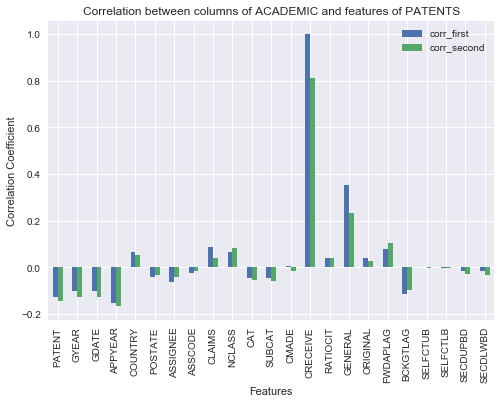

In [136]:
#Let's see our results
academic_correlations.plot.bar()
plt.xticks( range(23), patents.columns )
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.title("Correlation between columns of ACADEMIC and features of PATENTS")
plt.show()

According to the graph the academic impact of each patents are decreasing as time passes, which can be explained by increasing number of patents in each year. As expected, the CRECIEVE feature, which is number of citations recieved has highest correllation. But also note that it's value is 0.811 with second column of ACADEMIC dataset. And also, the generality which is measurement of how much scientific area does patent cover, has quite high correlation. In other words, the patents which covers wide area, have that much influence academically.

## Defining Economic Impact

The dataset provided by NBER doesn't have any information related to economy except the company names of each patents are assigned to. Thus, in this section, we have scraped Fortune magazine's rankings of top 500 companies in US over 1963 to 1999, with their revenues and profits in million (http://archive.fortune.com/magazines/fortune/fortune500_archive/full/). By combining these 2 datasets, we can get patents information of each company owns and their economic measurements for given year.

In [39]:
import requests
from bs4 import BeautifulSoup
import seaborn as sbn
#getting forbes data from 1963 to 1999
fortune=pd.DataFrame({'id':range(1,500*37+1),'year':0,'rank':0,'company':'','revenue':0,'profit':0})
fortune=fortune.set_index('id')
#This line is for just to match url with 
baseurl='http://archive.fortune.com/magazines/fortune/fortune500_archive/full/'
subs=['/1.html','/101.html','/201.html','/301.html','/401.html']
print('Started')
# Function for processing row. Which includes converting string values of profit and revenue to int and filling not available datas
def row_processor(row):
    cols=row.find_all('td')
    rank=int(cols[0].string)
    company=cols[1].a.string
    try:
        revenue=float(cols[2].string.replace(',', ''))
        profit=float(cols[3].string.replace(',', ''))
        return [rank,company,revenue,profit]
    except:
        return [rank,company,0,0]
y=0
#Looping over years
for year in range(1963,2000):
    #Looping over sub lists
    for lasturl in subs:
        #requesting
        r = requests.get(baseurl+str(year)+lasturl)
        soup = BeautifulSoup(r.text, 'html.parser')
        #Finding our table
        table = soup.find('table', class_='maglisttable')
        rows=table.find_all('tr',{"id": "tablerow"})
        #Saving them
        fortune['year'][range(y,y+100)]=year
        datas=[row_processor(row) for row in rows]
        fortune['rank'][range(y,y+100)]=[data[0] for data in datas]
        fortune['company'][range(y,y+100)]=[data[1] for data in datas]
        fortune['revenue'][range(y,y+100)]=[data[2] for data in datas]
        fortune['profit'][range(y,y+100)]=[data[3] for data in datas]
        y+=100
        #Just to see how things are going
        print(str(year)+lasturl)

Started


C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bilguun\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A

1963/1.html
1963/101.html
1963/201.html
1963/301.html
1963/401.html
1964/1.html
1964/101.html
1964/201.html
1964/301.html
1964/401.html
1965/1.html
1965/101.html
1965/201.html
1965/301.html
1965/401.html
1966/1.html
1966/101.html
1966/201.html
1966/301.html
1966/401.html
1967/1.html
1967/101.html
1967/201.html
1967/301.html
1967/401.html
1968/1.html
1968/101.html
1968/201.html
1968/301.html
1968/401.html
1969/1.html
1969/101.html
1969/201.html
1969/301.html
1969/401.html
1970/1.html
1970/101.html
1970/201.html
1970/301.html
1970/401.html
1971/1.html
1971/101.html
1971/201.html
1971/301.html
1971/401.html
1972/1.html
1972/101.html
1972/201.html
1972/301.html
1972/401.html
1973/1.html
1973/101.html
1973/201.html
1973/301.html
1973/401.html
1974/1.html
1974/101.html
1974/201.html
1974/301.html
1974/401.html
1975/1.html
1975/101.html
1975/201.html
1975/301.html
1975/401.html
1976/1.html
1976/101.html
1976/201.html
1976/301.html
1976/401.html
1977/1.html
1977/101.html
1977/201.html
1977/301

In [40]:
fortune.head()

,company,profit,rank,revenue,year
id,,,,,
1,General Motors,1459.1,1,14640.2,1963
2,Exxon Mobil,840.9,2,9536.9,1963
3,Ford Motor,480.7,3,8089.6,1963
4,General Electric,265.8,4,4792.7,1963
5,Mobil,242.3,5,3933.3,1963


Voila, we have successfully scraped out data. And now, we have to match the names of the companies between FORTUNE and PATENTS dataset. The Assignee id and company name conversion table is in coname file.

In [41]:
#matching coname with list companies
fort_names=fortune.company.unique()
fort_names.sort()
#Reading the company names
coname = pd.read_csv('data/coname.txt',low_memory=False)
conames=coname.COMPNAME.unique()
#Let's see company names of FORTUNE and PATENTS datasets.
print(fort_names)
print(conames)

['3Com' '3M' 'A-T-O' ..., 'Yum Brands' 'Zenith Electronics'
 'Zurn Industries']
['AAA ASSOCIATES, INC.' 'AAA OFFICE COFFEE SERVICE, INC.'
 'AAA PIPE CLEANING CORPORATION' ..., 'LUCAS NOVASENSOR INC.'
 'LOTS TECHNOLOGY, INC.' 'NEUTRAL POSTURE ERGONOMICS, INC.']


The company names of PATENTS dataset has only uppercase letters and have full names of companies and their sub-companies. However, in Fortune dataset, the companies names were summed up by their group names. Thus we have defined closest function, which returns the closest match between given name in the given list, and created company names conversion table between 2 datasets.

In [42]:
def closest(aname,bnames):
    for bname in bnames:
        if aname.startswith(bname.upper()):
            return bname
    return ''
coname['fortune']=[closest(aname,fort_names) for aname in coname.COMPNAME]

In [43]:
coname.head()

,ASSIGNEE,COMPNAME,fortune
0,5,"AAA ASSOCIATES, INC.",
1,10,"AAA OFFICE COFFEE SERVICE, INC.",
2,15,AAA PIPE CLEANING CORPORATION,
3,20,AAA PRODUCTS INTERNATIONAL INC.,
4,25,"AAA SALES & ENGINEERING, INC.",


Voila, Our table is finished. Now let's look at some characteristics

In [44]:
sum(coname['fortune']=='')

169829

In [45]:
len(fort_names)

1564

According to our table, we couldn't found the match of almost 170k companies mentioned in PATENTS. However, note that in fortune dataset, there is only information about 1564 top companies

In [46]:
#Removing companies that we couldn't found the match
companies=coname[coname['fortune']!='']
companies

,ASSIGNEE,COMPNAME,fortune
132,735,ABBOTT LABORATORIES,Abbott Laboratories
266,1450,ABEX CORPORATION,Abex
267,1455,ABEX INDUSTRIES OF CANADA LTD.,Abex
268,1460,ABEX PAGID REIBBELAG GMBH,Abex
642,3470,ACCO INDUSTRIES INC.,Acco Industries
794,4235,"ACF INDUSTRIES, INCORPORATED",ACF Industries
1274,6800,"ADMIRAL COATED PRODUCTS, INC.",Admiral
1275,6805,ADMIRAL CORPORATION,Admiral
1276,6810,ADMIRAL DESIGN AND RESEARCH LIMITED,Admiral
1277,6815,ADMIRAL EQUIPMENT COMPANY,Admiral


Looks like our conversion was pretty successful. So let's see how much patents these top companies own

In [47]:
relevant=patents[patents['ASSIGNEE'].isin(companies['ASSIGNEE'])]

In [48]:
relevant.shape[0]/patents.shape[0]

0.17032020690018407

In [49]:
len(companies.COMPNAME.unique())/len(coname)

0.030185877851697455

Surprisingly almost __17%__ of the total patents is owned by only 1564 top groups. Moreover, it is only __3%__ of the companies that were mentioned in the PATENTS dataset. 

### What features influence on economic impact of patents?
In order to answer this question, we have used the similar method as academic.

Started correlation calculation
-0.0213203401391 -0.0422453354097
-0.0217457860455 -0.0396659090125
-0.0217883392141 -0.0397457584399
-0.0211605516913 -0.036280294647
0.0592645284382 0.0724278851798
0.0320731672308 0.0271710759772
0.254264609894 0.113654548651
-0.0501910581009 -0.0704899887271
-0.0354581558307 -0.0656654993055
-0.0194901570245 -0.0246796408844
0.00366721711945 0.0135367083695
-0.00901316875182 0.00419028951978
-0.0348089658356 -0.0366109238712
0.0415355258836 0.0281675095513
0.0450003762999 0.0214189461256
0.0171702000503 0.00602236962353
-0.0135009082886 -0.0214123304177
-0.00732254650581 -0.00405689799669
-0.068540898039 -0.0464820507718
0.0138270172518 0.0195287843405
0.019733339128 0.0203710641474
-0.0344442077654 -0.0245018606325
-0.0340746627887 -0.0240255886083


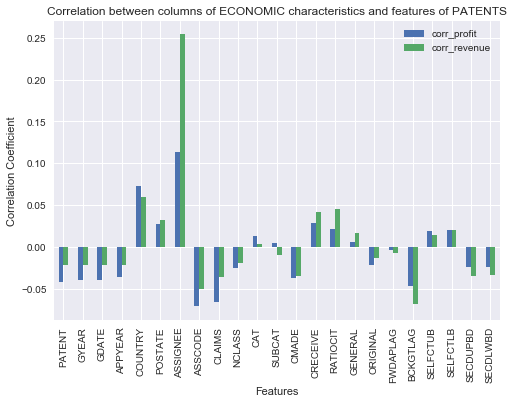

In [138]:
#Preparint the data
X=[]
e_revenue=[]
e_profit=[]
cnames=companies.fortune.unique()
#For each companies
for cname in cnames:
    #Find sub companies names
    c_fortune=fortune[fortune.company==cname]
    #Find sub companies assignee ids
    sub_companies_id=companies[companies.fortune==cname].ASSIGNEE
    #Filter patents info only related to this company
    c_relevant=relevant[relevant['ASSIGNEE'].isin(sub_companies_id)]
    #Save it
    X.append(c_relevant)
    #Save the economic characteristics
    e_revenue+=[c_fortune.revenue.iloc[0]]*len(c_relevant)
    e_profit+=[c_fortune.profit.iloc[0]]*len(c_relevant)
#Little bit conversion for sake of further analysis
X=pd.concat(X)
e_revenue=pd.Series(e_revenue)
e_profit=pd.Series(e_profit)

#Exactly same thing as academic
cors_revenue=[]
cors_profit=[]
print("Started correlation calculation")
X = X.fillna({'COUNTRY': 'None','POSTATE': 'None'})
for cat in ['COUNTRY','POSTATE']:
        X[cat]=LabelEncoder().fit_transform(X[cat])
X=X.reset_index().drop('index',axis=1)
for cat in X.columns:
    a=X[cat].corr(e_revenue)
    b=X[cat].corr(e_profit)
    cors_revenue.append(a)
    cors_profit.append(b)
    print(a,b)
    
#Let's see our results
economic_correlations=pd.DataFrame({"features":patents.columns,"corr_revenue":cors_revenue,"corr_profit":cors_profit})
economic_correlations.plot.bar()
plt.xticks( range(23), patents.columns )
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.title("Correlation between columns of ECONOMIC characteristics and features of PATENTS")
plt.show()

Obviously, the Assignee id has the highest correlation with revenues and profits. For the features related to time, we can see the same relationship with Academic correlations. Which also can be explained increasing number of patents. However, the inventor's country plays big impact on economic impact, which is different from academics. And also, the number of claims each patent has negative influence on economics, while it was opposite in academics. But we can see interesting results in citation related features. For example, the number of citations made and originality of patent influence negatively in economy. And citations recieved has some degree of correlation (0.045).

## The Comparison between Academic and Economic impacts
Now, since we have evaluated quantative measurements of both academic and economical impacts, let's see their relationships. To do so, we first calculated total number of citations of each company's patents has and the compared it with it's revenue and profits using pair plot and correlation matrix

In [76]:
#Declaring the variables to save the data
a_first=[]
a_second=[]
e_revenue=[]
e_profit=[]
cnames=companies.fortune.unique()
#Again for each company
for cname in cnames:
    c_fortune=fortune[fortune.company==cname]
    sub_companies_id=companies[companies.fortune==cname].ASSIGNEE
    #Find patents info specific to give company
    c_relevant=relevant[relevant['ASSIGNEE'].isin(sub_companies_id)]
    #Find Academic values according to the patent ids
    conds=c_relevant["PATENT"].isin(academic.index.values)
    first=pd.Series([academic['first'][indice] if cond else 0 for indice,cond in zip(c_relevant['PATENT'],conds)])
    second=pd.Series([academic['second'][indice] if cond else 0 for indice,cond in zip(c_relevant['PATENT'],conds)])    
    #Then sum up number of citations to find total number of citations of each company's patents
    a_first.append(first.sum())
    a_second.append(second.sum())
    e_revenue.append(c_fortune.revenue.iloc[0])
    e_profit.append(c_fortune.profit.iloc[0])

a_e_impacts=pd.DataFrame({'a_first':a_first,
                          'a_second':a_second,
                          'e_revenue':e_revenue,
                          'e_profit':e_profit})
a_e_impacts.head()

,a_first,a_second,e_profit,e_revenue
0,11241,54435.0,14.8,144.1
1,1074,4166.0,7.0,194.5
2,164,849.0,7.2,257.6
3,2515,9155.0,6.0,214.3
4,332,1525.0,2.0,183.2


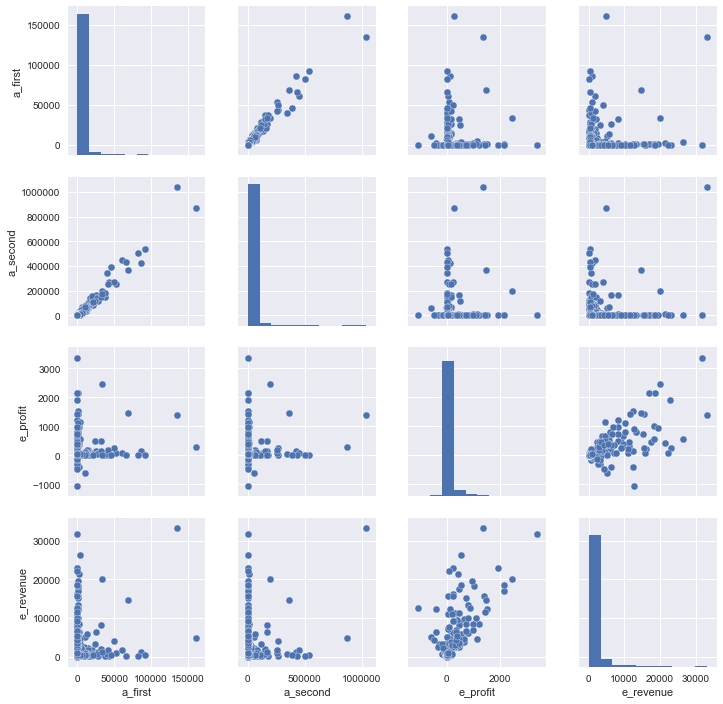

In [77]:
#Now let's make pairplot to see if there is any relationship
import seaborn as sbn
sbn.pairplot(a_e_impacts)
plt.show()

In [80]:
a_e_impacts.corr()

,a_first,a_second,e_profit,e_revenue
a_first,1.000000,0.981324,0.129647,0.152929
a_second,0.981324,1.000000,0.138330,0.178065
e_profit,0.129647,0.138330,1.000000,0.721028
e_revenue,0.152929,0.178065,0.721028,1.000000


The highest relation between academic and economic feature was shown in "second" in ACADEMIC and company's revenues. However, the correlation is still low and it might seem there is no correlation between academic and economic impact. But note that, this analysis is time independent and we have no knowledge about citations of patents that companies already had before 1975.

## The Comparison between Academic and Economic impacts with TIME

In this section, we are dividing the previous analysis on each year. Note that instead of number of citations of each year, we took cumulative sum. The reason is, we also have to take account that given company has already owned previous patents, influencing company's success. And also, we have used column "second" in ACADEMIC dataset for measuring academic impact, since it has considerably large correlation with "first" column.

In [50]:
#Creating Json
cnames=companies.fortune.unique()
d=[]
#Custom functions to help to get data and fill NA values
def filler(dataset,rcolumn,ycolumn,year):
    tmp=dataset[rcolumn][dataset[ycolumn]==year]
    if len(tmp)==0:
        return pd.Series([1])
    else:
        return tmp
def filler_idx(series,year):
    try:
        return series[year]
    except:
        return 0
# For each company
for cname in cnames:
    #Let's find Revenues of each year. 0 if company is not mentioned in fortune list
    c_fortune=fortune[fortune.company==cname]
    revenue=[[int(a),float(filler(c_fortune,'revenue','year',a).iloc[0])] for a in range(1963,2000)]
    
    #As usual, finding patents info only related to given company
    sub_companies_id=companies[companies.fortune==cname].ASSIGNEE
    c_relevant=relevant[relevant['ASSIGNEE'].isin(sub_companies_id)]
    
    #Finding cumulative sum of patents owned by company by year
    tmp=c_relevant.groupby('GYEAR').count()['PATENT']
    tmp=np.cumsum([filler_idx(tmp,y) for y in range(1963,2000)])
    p_cnt=[[int(a),float(b)] for a,b in zip(range(1963,2000),tmp)]
    
    #Finding cumulative sum of patents owned by company by year
    tmp=np.cumsum([int(academic['second'][filler(c_relevant,'PATENT','GYEAR',year)].sum()) for year in range(1963,2000)])
    p_cit=[[int(a),float(b)] for a,b in zip(range(1963,2000),tmp)]
    
    #Finding the most common technological category of each company's patents
    categories=pd.concat([filler(c_relevant,'CAT','GYEAR',year).value_counts() for year in range(1963,2000)],axis=1).fillna(0)
    p_cat=[[int(1963+column),int(np.argmax(categories.ix[:,column]))] for column in range(categories.shape[1])]
    d.append({'c_name':cname,
              'c_revenue':revenue,
              'p_citation':p_cit,
              'p_count':p_cnt,
              'p_category':p_cat
             })
    #Just to monitor if everything is working fine
    if(len(d)%10==0):
        print(100*len(d)/len(cnames))

C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1.0416666666666667
2.0833333333333335
3.125
4.166666666666667
5.208333333333333
6.25
7.291666666666667
8.333333333333334
9.375
10.416666666666666
11.458333333333334
12.5
13.541666666666666
14.583333333333334
15.625
16.666666666666668
17.708333333333332
18.75
19.791666666666668
20.833333333333332
21.875
22.916666666666668
23.958333333333332
25.0
26.041666666666668
27.083333333333332
28.125
29.166666666666668
30.208333333333332
31.25
32.291666666666664
33.333333333333336
34.375
35.416666666666664
36.458333333333336
37.5
38.541666666666664
39.583333333333336
40.625
41.666666666666664
42.708333333333336
43.75
44.791666666666664
45.833333333333336
46.875
47.916666666666664
48.958333333333336
50.0
51.041666666666664
52.083333333333336
53.125
54.166666666666664
55.208333333333336
56.25
57.291666666666664
58.333333333333336
59.375
60.416666666666664
61.458333333333336
62.5
63.541666666666664
64.58333333333333
65.625
66.66666666666667
67.70833333333333
68.75
69.79166666666667
70.83333333333333


In [31]:
#Saving our file into json format
import json
djson=json.dumps(d, separators=(',',':'))
f = open('patentImpact.txt','w')
f.write(djson)
f.close()

!!!GRAPH DESCRIPTION

In [64]:
# Now let's try correlation again
from sklearn.linear_model import LinearRegression
a_e_cors=[]
a_e_cofs=[]
for year in range(1975-1963,2000-1963):
    c_revs=[]
    c_cits=[]
    for company in d:
        c_revs.append(company["c_revenue"][year][1])
        c_cits.append(company["p_citation"][year][1])
    a_e_cors.append(pd.Series(c_revs).corr(pd.Series(c_cits)))
    a_e_cofs.append(LinearRegression(fit_intercept=False).fit([[x,1] for x in c_cits],c_revs).coef_)

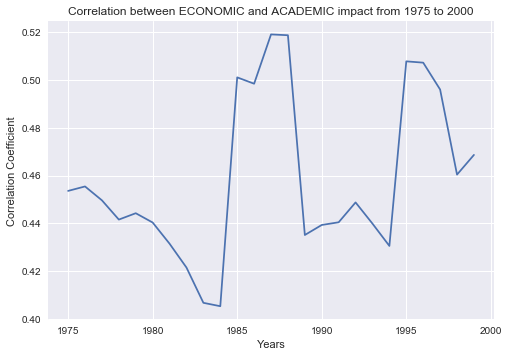

In [65]:
plt.plot(range(1975,2000),a_e_cors)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Years")
plt.title("Correlation between ECONOMIC and ACADEMIC impact from 1975 to 2000")
plt.show()

In [79]:
djson=json.dumps([[a,b[0]] for a,b in zip(a_e_cors,a_e_cofs)], separators=(',',':'))
f = open('relationships','w')
f.write(djson)
f.close()

In general the correlation now is pretty high and showing clear evidence that ACADEMIC impact indead influence on ECONOMY. But interestengly, this graph might be inferring some historical events. For example around early 1980, there was global economical recession happened and it was ended around 1984. And also, through 1989 to 1991, due to inconvenient government policy economical recession happened. However the 1990 to 2000 is considered the golden years of US economy and in 1994 the number of jobs created were peaked. https://en.wikipedia.org/wiki/1990s_United_States_boom, https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States. Even though it is tempting to say that economic and academic relationship is somehow related to nations economical state and policy, further research and expertise are needed.

## Can we predict Academic impact?
According to the correlation analysis on these two impact, the features provided to us is not sufficient for building reliable prediction model. But we are trying it anyway. To predict how many citations do patents can have we have used Random Forest Regression for our model and mean absolute error to evaluate our model.

In [80]:
#Useful functions for ML
#Following features are categorical. Thus we are using OneHotEncoder on those features
OHE=OneHotEncoder(categorical_features=[4,5,7,10])
def prepare_x(X):
    #Filling NA values
    cats=['COUNTRY','POSTATE','ASSCODE','CAT']
    X = X.fillna({cats[0]: 'None',
                  cats[1]: 'None'})
    X=X.fillna(-1)
    print("Finished Filling")
    #Coding categorical values
    for cat in ['COUNTRY','POSTATE']:
        X[cat]=LabelEncoder().fit_transform(X[cat])
    X=OHE.fit_transform(X)
    print("Finished Encoding")
    return X
#This function splits the dataset into 80% training, 10% validation and 10% testing
def splitter(length):
    train_i=random.sample(range(0,length),int(length*0.8))
    test_i=list(set(range(0,length))-set(train_i))
    valid_i=random.sample(test_i,int(len(test_i)*0.5))
    test_i=list(set(test_i)-set(valid_i))
    print("Splitted dataset: {tr} - for training, {va} - for validation, {te} - for testing".format(tr=len(train_i),va=len(test_i),te=len(valid_i)))
    return train_i,test_i,valid_i
#This function prepares our data (How wonderful is that!)
def data_preparer(patent,academic,ycols):
    X=prepare_x(patent)
    conds=patent["PATENT"].isin(academic.index.values)
    Y1=np.array([academic[ycols[0]][indice] if cond else 0 for indice,cond in zip(patent['PATENT'],conds)])
    Y2=np.array([academic[ycols[1]][indice] if cond else 0 for indice,cond in zip(patent['PATENT'],conds)])
    return X.tocsr(),Y1,Y2

In [84]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=10, max_depth=100)

train_i,test_i,valid_i=splitter(patents.shape[0])
X,Y1,Y2=data_preparer(patents.drop('CRECEIVE',axis=1),academic,['first','second'])

model.fit(X[train_i,:],Y1[train_i])
abs_errs=np.absolute(Y1[test_i]-model.predict(X[test_i,:]))
print("Mean Absolute Error")
print(pd.Series(abs_errs).mean())
print("--------------------------------------------")
print("Mean value of citations recieved")
print(pd.Series(Y1).mean())

Mean Absolute Error
1.0685686729846473
--------------------------------------------
Mean value of citations recieved
4.779235903009725


## Citation lag
The forward lags focus on the time difference between the application or grant year of the cited patent, and that of the citing patents. And thus, we can measure probability of recieving citation since the grant.

In [21]:
#Calculating the histogram
forward_lag=patents['FWDAPLAG'][patents['FWDAPLAG'].notnull()]
count, division = np.histogram(forward_lag, bins = 100)

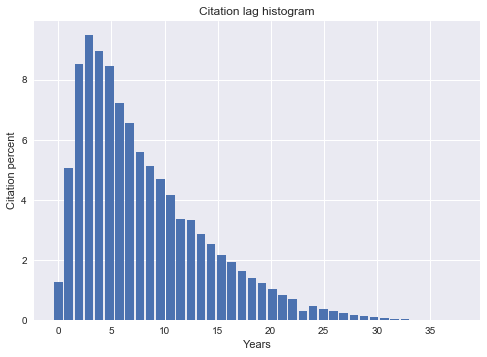

In [28]:
#Normalizing and displaying the histogram
plt.bar(division[0:40],count[0:40]*100/sum(count))
plt.ylabel("Citation percent")
plt.xlabel("Years")
plt.title("Citation lag histogram")
plt.show()

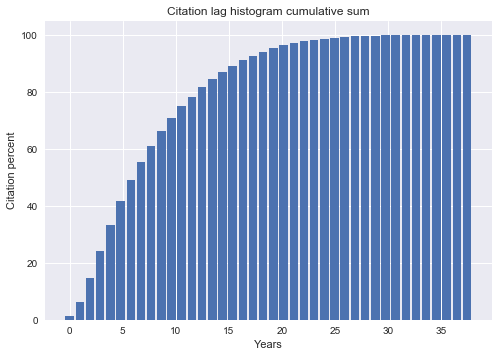

In [29]:
plt.bar(division[0:40],np.cumsum(count[0:40]*100/sum(count)))
plt.ylabel("Citation percent")
plt.xlabel("Years")
plt.title("Citation lag histogram cumulative sum")
plt.show()

According to our graph, almost 40 % of the total citations were made within 5 years since the grant, and 80 % after 13 years.